In [8]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
from sklearn import linear_model

def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd:
        data.append(lv)
    header = data[0]
    infectionData=(data[1:])
    infectionData = np.array(infectionData)
    dates = infectionData[:,0]
    dates = dates.tolist()
    infected = infectionData[:,1]
    tested = infectionData[:,2]
    recovered = infectionData[:,3]
    deaths = infectionData[:,4]
    deaths = deaths.astype(np.float)
    recovered = recovered.astype(np.float)
    tested = tested.astype(np.float)
    infected = infected.astype(np.float)
    return dates, infected, tested, recovered, deaths

def showCurves(dates, infected, tested, recovered, dead):
    popITA = 60000000
    q = .014
    #since S+I+R+D always equals the same constant S(t) can now be determined
    suscept = q*popITA - infected - recovered - dead
    sirdMatrix = np.zeros((len(recovered) - 1, 4, 4))
    nextIterMatrix = np.zeros((len(recovered) - 1, 4, 1)) #the S(t+1), I(t+1), ... matrix

    #populate the 4x4 matrix with parameters (see above note)
    sirdMatrix[:,0,0] = suscept[0:-1]
    sirdMatrix[:,0,1] = -(suscept[0:-1] * infected[0:-1]) / (suscept[0:-1] + infected[0:-1])

    sirdMatrix[:,1,0] = infected[0:-1]
    sirdMatrix[:,1,1] = (suscept[0:-1] * infected[0:-1]) / (suscept[0:-1] + infected[0:-1])
    sirdMatrix[:,1,2] = -infected[0:-1]
    sirdMatrix[:,1,3] = -infected[0:-1]

    sirdMatrix[:,2,0] = recovered[0:-1]
    sirdMatrix[:,2,2] = infected[0:-1]

    sirdMatrix[:,3,0] = dead[0:-1]
    sirdMatrix[:,3,3] = infected[0:-1]

    #populate the S(t+1), I(t+1), ... matrix
    nextIterMatrix[:,0,0] = suscept[1:]
    nextIterMatrix[:,1,0] = infected[1:]
    nextIterMatrix[:,2,0] = recovered[1:]
    nextIterMatrix[:,3,0] = dead[1:]

    #clf = linear_model.Lasso(alpha=10)
    #clf.fit(sirdMatrix, nextIterMatrix)
    #coef = clf.coef_
    paramMatrix = np.linalg.solve(sirdMatrix, nextIterMatrix) #solve Ax = B, where A = sirdMatrix, and B = nextIterMatrix

    #copy params over from the solved matrix
    transRate = paramMatrix[:,1,0] #beta
    recovRate = paramMatrix[:,2,0] #gamma
    deathRate = paramMatrix[:,3,0] #upsilon
    
    transRateSect = transRate[0:120]
    recovRateSect = recovRate[0:120]
    deathRateSect = deathRate[0:120]
    
    fig, ax = plt.subplots(3, 1, figsize=(18,8))

    x=range(0, len(transRateSect))
    xPlot = np.linspace(x[0], x[-1])

    poly = np.poly1d(np.polyfit(x, transRateSect, 3))
    yPlot = poly(xPlot)
    ax[0].plot(xPlot, yPlot, color='orange', label='Transmission Rate')

    poly = np.poly1d(np.polyfit(x, recovRateSect, 1))
    yPlot = poly(xPlot)
    ax[1].plot(xPlot, yPlot, color='green', label='Recovery Rate')

    poly = np.poly1d(np.polyfit(x, deathRateSect, 3))
    yPlot = poly(xPlot)
    ax[2].plot(xPlot, yPlot, color='black', label='Death Rate')

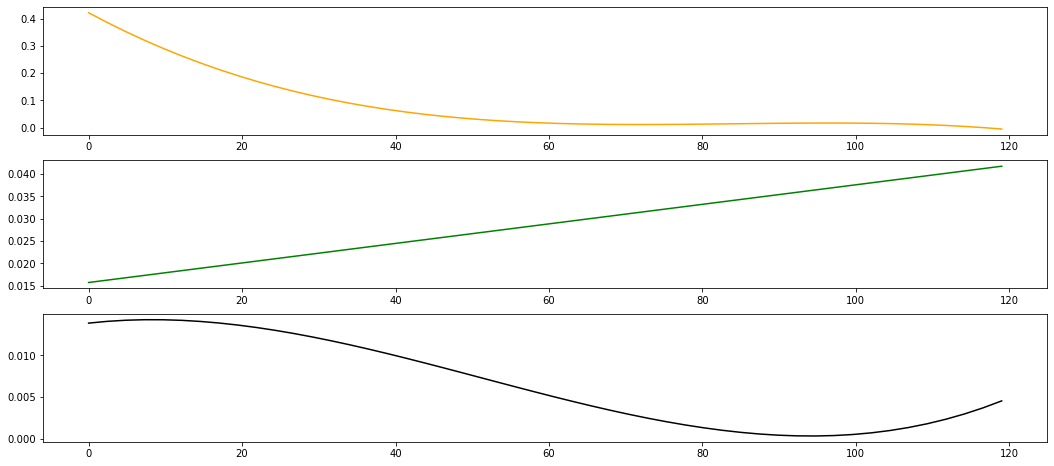

In [12]:
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "National Data.csv"

dates,infectRaw, natTested, recovRaw, deadRaw = loadData(pathc + filename)
showCurves(dates,infectRaw,natTested,recovRaw, deadRaw)